In [1]:
import serial
import serial.tools.list_ports
import time
import matplotlib.pyplot as plt
from coincidence_counter_driver import CoincidenceCounter
from motor_driver import MotorDriver
from bi_photon_source import BiPhotonSource
from lcc_driver import *
import numpy as np

In [2]:
#pip install pyserial

In [3]:
GROUP_NAME = 'Fr 1pm'

## check which usb ports are connected

In [4]:
ports = serial.tools.list_ports.comports()

for port, desc, hwid in sorted(ports):
        print(f"{port}:\t{desc} [{hwid}]")

COM1:	Communications Port (COM1) [ACPI\PNP0501\0]
COM21:	USB Serial Port (COM21) [USB VID:PID=0403:6001 SER=04458684A]


## live plotting function

In [12]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
import collections
%matplotlib inline

def live_plot(data_dict: dict, x_axis, x_axis_label = '', title='', figsize=(7,5)):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label, data in data_dict.items():
        plt.plot(x_axis, data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel(x_axis_label)
    plt.ylabel('counts')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show()

## initialize instruments

In [5]:
motor = MotorDriver('COM20')

In [7]:
coin = CoincidenceCounter('COM4')

In [12]:
bi = BiPhotonSource('COM2')

## set coincidence counter settings

In [8]:
coin.ch1_delay = 0
coin.ch1_delay

'0 ns'

In [9]:
coin.dwell_time = 0.1 #s
coin.dwell_time

'100 ms'

In [7]:
coin.coincidence_window = 3 #ns 
coin.coincidence_window

'3 ns'

In [11]:
counts = coin.measure_channels()
print(f" ch1: {counts[0]}\n ch2: {counts[1]}\n coincidences: {counts[2]}")

 ch1: 120579
 ch2: 93696
 coincidences: 2848


# Temporal sensitivity of bi-photons

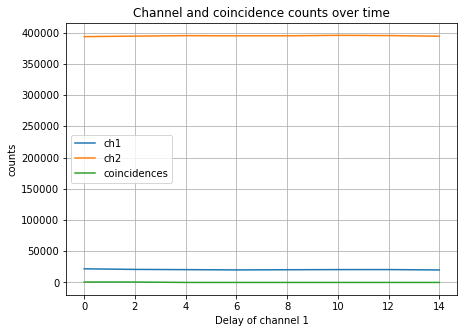

In [16]:
data_dict = {
    'ch1': [],
    'ch2': [],
    'coincidences': []
}
x_axis = []
for i in range(8):
    coin.ch1_delay = int(2*i)
    time.sleep(0.2)
    ch1, ch2, coincidences = coin.measure_channels()
    data_dict['ch1'].append(ch1)
    data_dict['ch2'].append(ch2)
    data_dict['coincidences'].append(coincidences)
    x_axis.append(2*i)
    live_plot(data_dict, x_axis,
              x_axis_label = "Delay of channel 1",
              title = 'Channel and coincidence counts over time')

# Hong-Ou-Mandel (HOM) experiment

In [13]:
coin.measure_channels()

(121163, 93870, 2921)

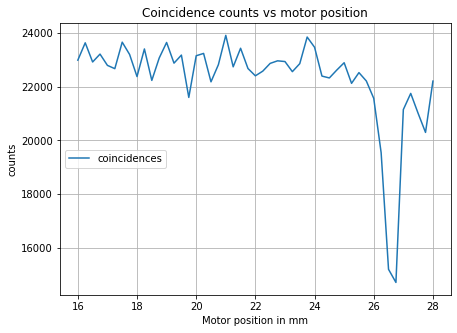

In [35]:
hom_counts = {
    'ch1': [],
    'ch2': [],
}
hom_coincidences = {
    'coincidences': []
}
x_axis = []

coin.dwell_time = 0.1
coin.coincidence_window = 3
coin.ch1_delay = 0

step = 0.25
steps = np.arange(16, 28+step, step)
print(steps)
steps = np.flip(steps)
for i in steps:
    aim = i
    print(aim)
    motor.position = aim

    t0 = time.time()
    while abs(motor.position - aim) > 0.1:
        print(
            f"Current position is {motor.position:.2f} mm moving to {aim} mm",
            end  = '\r')
        if (time.time()-t0) > 2:
            motor.position = aim
            t0 = time.time()
        time.sleep(0.01)
    ch1, ch2, coincidences = coin.measure_channels()
    hom_counts['ch1'].append(ch1)
    hom_counts['ch2'].append(ch2)
    hom_coincidences['coincidences'].append(coincidences)
    x_axis.append(i)
    live_plot(hom_coincidences, x_axis,
              x_axis_label = "Motor position in mm",
              title = 'Coincidence counts vs motor position')

### SAVE THE DATA
# hom_data = hom_coincidences | hom_counts
# timestr = time.strftime("%Y%m%d-%H%M%S")
# with open(f'data/{GROUP_NAME}_exp4_HOM_{timestr}.txt', 'w') as f:
#     print(hom_data, file=f)

In [101]:
maxx = max(hom_counts['ch1'])
minn = min(hom_counts['ch1'])
avg = np.average(hom_counts['ch1'])
std = np.std(hom_counts['ch1'])

print(maxx, minn, avg, std)

42290.0 41031.0 41790.2 342.26329046510375


In [102]:
maxx = max(hom_counts['ch2'])
minn = min(hom_counts['ch2'])
avg = np.average(hom_counts['ch2'])
std = np.std(hom_counts['ch2'])

print(maxx, minn, avg, std)

401865.0 396177.0 399445.9 1922.1977239607793


In [ ]:
### SAVE THE DATA
hom_data = hom_coincidences,hom_counts
timestr = time.strftime("%Y%m%d-%H%M%S")
with open(f'data/45000_exp4_HOM_{timestr}.txt', 'w') as f:
    print(hom_data, file=f)

# continuous live plot

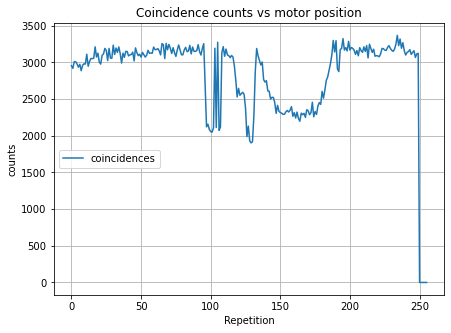

KeyboardInterrupt: 

In [15]:
# continuous measurement
coin.measure_channels()
hom_counts = {
    'ch1': [],
    'ch2': [],
}
hom_coincidences = {
    'coincidences': []
}
x_axis = []

coin.dwell_time = 0.1
coin.coincidence_window = 3
coin.ch1_delay = 0

for i in range(1000):
    time.sleep(0.2)
    ch1, ch2, coincidences = coin.measure_channels()
    hom_counts['ch1'].append(ch1)
    hom_counts['ch2'].append(ch2)
    hom_coincidences['coincidences'].append(coincidences)
    x_axis.append(i)
    live_plot(hom_coincidences, x_axis,
              x_axis_label = "Repetition",
              title = 'Coincidence counts vs. Repetition')

## calculate statistics

In [1]:
maxx = max(hom_coincidences['coincidences'])
minn = min(hom_coincidences['coincidences'])
avg = np.average(hom_coincidences['coincidences'])
std = np.std(hom_coincidences['coincidences'])

print(maxx, minn, avg, std)

# Entanglement lab 5

## set lcc settings

In [2]:
lcc = LCC25('COM21')

LCC25 device 04458684 connected on COM21 (handle=0).


In [5]:
lcc.output_mode = 'voltage1'
lcc.voltage1 = 0
lcc.output_enable = True

## measure coincidences vs. LCVR voltage

In [9]:
# measurement settings
voltages = np.linspace(0, 15, 200) # fill in


# continuous measurement
coin.measure_channels()
hom_counts = {
    'ch1': [],
    'ch2': [],
}
hom_coincidences = {
    'coincidences': []
}
x_axis = []

# coincidence counter settings
coin.dwell_time = 0.1
coin.coincidence_window = 3
coin.ch1_delay = 0

for i, v in enumerate(voltages):
    time.sleep(0.2)
    lcc.voltage1 = v
    ch1, ch2, coincidences = coin.measure_channels()
    hom_counts['ch1'].append(ch1)
    hom_counts['ch2'].append(ch2)
    hom_coincidences['coincidences'].append(coincidences)
    x_axis.append(i)
    live_plot(hom_coincidences, x_axis,
              x_axis_label = "Repetition",
              title = 'Coincidence counts vs. LCVR voltage')

NameError: name 'coin' is not defined